In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manashnepal","key":"94cabe5ddf93c8fe58c4b31f8cf8c6d2"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API token configured successfully.")

Kaggle API token configured successfully.


In [3]:
# Download the dataset from Kaggle
!kaggle datasets download -d ninadaithal/oasis-1-shinohara

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/oasis-1-shinohara
License(s): CC0-1.0
 78% 308M/397M [00:00<00:00, 889MB/s] 
100% 397M/397M [00:00<00:00, 584MB/s]


In [4]:
import zipfile
import os

zip_file_path = 'oasis-1-shinohara.zip'

# Unzip the file
print(f"Unzipping {zip_file_path}...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

os.remove(zip_file_path)

print("Dataset Downloaded and Unzipped Successfully!")

Unzipping oasis-1-shinohara.zip...
Dataset Downloaded and Unzipped Successfully!


In [5]:
import pandas as pd

csv_path = 'oasis_cross-sectional.csv'
df = pd.read_csv(csv_path)

# Data Cleaning

# Define the columns to use
columns_to_keep = [
    'ID',     # to link to the MRI images
    'CDR',    # target label (the dementia stage)
    'Age',
    'M/F',
    'Educ',
    'SES',
    'MMSE'
]

# new cleaner DataFrame with just these columns
df_clean = df[columns_to_keep].copy()

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   CDR     436 non-null    float64
 2   Age     436 non-null    int64  
 3   M/F     436 non-null    object 
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 24.0+ KB


In [7]:
# Define columns we need to fill
impute_cols = ['Educ', 'SES', 'MMSE']

for col in impute_cols:
    # Calculate the median value for the column
    median_value = df_clean[col].median()

    # Fill the missing values in that column with the median
    df_clean[col] = df_clean[col].fillna(median_value)

    print(f"Missing values in '{col}' filled with median: {median_value}")

Missing values in 'Educ' filled with median: 3.0
Missing values in 'SES' filled with median: 2.0
Missing values in 'MMSE' filled with median: 29.0


In [8]:
print("\nImputed DataFrame Info")
df_clean.info()


Imputed DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   CDR     436 non-null    float64
 2   Age     436 non-null    int64  
 3   M/F     436 non-null    object 
 4   Educ    436 non-null    float64
 5   SES     436 non-null    float64
 6   MMSE    436 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 24.0+ KB


In [9]:
# Target label distribution
print("\nFull Distribution of Dementia Stages (CDR)")
label_counts = df_clean['CDR'].value_counts().sort_index()
print(label_counts)


Full Distribution of Dementia Stages (CDR)
CDR
0.0    336
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64


In [10]:
scan_directory = './oasis/OASIS/'
image_path_map = {}

try:
    all_scan_files = os.listdir(scan_directory)

    # Loop over every file
    for filename in all_scan_files:
        if filename.endswith(".nii"):
            patient_id = filename.split('_mpr')[0].strip()

            full_path = os.path.join(scan_directory, filename)
            image_path_map[patient_id] = full_path

    print(f"Created a map with {len(image_path_map)} entries.")

    # Create the 'image_path' column
    df_clean['image_path'] = df_clean['ID'].map(image_path_map)

    # Final verification
    print("\n\nDataFrame with new 'image_path' column")
    print(df_clean.head())

    # Check for missing paths
    missing_paths = df_clean['image_path'].isna().sum()
    print(f"\nNumber of rows with missing image paths: {missing_paths}")

    # Drop any rows that still don't have a match
    if missing_paths > 0:
        print(f"Dropping {missing_paths} rows that had no matching MRI file.")
        df_clean = df_clean.dropna(subset=['image_path'])

    print(f"New total entries in df_clean: {len(df_clean)}")

except FileNotFoundError:
    print(f"ERROR: The directory '{scan_directory}' was not found.")

Created a map with 436 entries.


DataFrame with new 'image_path' column
              ID  CDR  Age M/F  Educ  SES  MMSE  \
0  OAS1_0001_MR1  0.0   74   F   2.0  3.0  29.0   
1  OAS1_0002_MR1  0.0   55   F   4.0  1.0  29.0   
2  OAS1_0003_MR1  0.5   73   F   4.0  3.0  27.0   
3  OAS1_0004_MR1  0.0   28   M   3.0  2.0  29.0   
4  OAS1_0005_MR1  0.0   18   M   3.0  2.0  29.0   

                                          image_path  
0  ./oasis/OASIS/OAS1_0001_MR1_mpr_n4_anon_sbj_11...  
1  ./oasis/OASIS/OAS1_0002_MR1_mpr_n4_anon_sbj_11...  
2  ./oasis/OASIS/OAS1_0003_MR1_mpr_n4_anon_sbj_11...  
3  ./oasis/OASIS/OAS1_0004_MR1_mpr_n4_anon_sbj_11...  
4  ./oasis/OASIS/OAS1_0005_MR1_mpr_n4_anon_sbj_11...  

Number of rows with missing image paths: 0
New total entries in df_clean: 436


In [11]:
df_clean.head()

,ID,CDR,Age,M/F,Educ,SES,MMSE,image_path
0,OAS1_0001_MR1,0.0,74,F,2.0,3.0,29.0,./oasis/OASIS/OAS1_0001_MR1_mpr_n4_anon_sbj_11...
1,OAS1_0002_MR1,0.0,55,F,4.0,1.0,29.0,./oasis/OASIS/OAS1_0002_MR1_mpr_n4_anon_sbj_11...
2,OAS1_0003_MR1,0.5,73,F,4.0,3.0,27.0,./oasis/OASIS/OAS1_0003_MR1_mpr_n4_anon_sbj_11...
3,OAS1_0004_MR1,0.0,28,M,3.0,2.0,29.0,./oasis/OASIS/OAS1_0004_MR1_mpr_n4_anon_sbj_11...
4,OAS1_0005_MR1,0.0,18,M,3.0,2.0,29.0,./oasis/OASIS/OAS1_0005_MR1_mpr_n4_anon_sbj_11...


In [12]:
# For reading neuroimaging files
!pip install nibabel

In [13]:
import nibabel as nib  # For loading .nii files
import numpy as np      # For numerical operations
from scipy.ndimage import zoom  # For 3D resizing

# Standard size for all our 3D images
IMG_SIZE = 128

def process_scan(path):
    """
    Loads a 3D MRI scan, resizes, and normalizes it.
    """
    try:
        # Load the scan
        img = nib.load(path)

        # Get the raw 3D data as a numpy array
        img_data = img.get_fdata()

        # Resize the 3D image
        # Calculate the zoom factors to get to IMG_SIZE
        original_shape = img_data.shape
        zoom_factors = (
            IMG_SIZE / original_shape[0],
            IMG_SIZE / original_shape[1],
            IMG_SIZE / original_shape[2]
        )

        # Resize using 'zoom'
        img_resized = zoom(img_data, zoom_factors, order=1, prefilter=False)

        # Normalize the image between 0 and 1
        img_normalized = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized))

        # Add a channel dimension (for the 3D CNN). Change shape from (128, 128, 128) to (128, 128, 128, 1)
        img_final = img_normalized[..., np.newaxis]

        # Return the processed image as a 32-bit float to save memory
        return img_final.astype(np.float32)

    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

In [14]:
# Get the image path for the very first patient
first_patient_path = df_clean.loc[0, 'image_path']
print(f"\nLoading and processing test scan:")
print(f"Path: {first_patient_path}")

# Process the scan
processed_image = process_scan(first_patient_path)

# Check results
if processed_image is not None:
    print(f"\nSuccessfully processed scan")
    print(f"Original shape (approx): (256, 256, 176)")
    print(f"New shape: {processed_image.shape}")
    print(f"Data type: {processed_image.dtype}")
    print(f"Min value: {np.min(processed_image)}")
    print(f"Max value: {np.max(processed_image)}")
else:
    print("Failed to process the test scan.")


Loading and processing test scan:
Path: ./oasis/OASIS/OAS1_0001_MR1_mpr_n4_anon_sbj_111_normalised.nii

Successfully processed scan
Original shape (approx): (256, 256, 176)
New shape: (128, 128, 128, 1)
Data type: float32
Min value: 0.0
Max value: 1.0


In [15]:
# Visualize "Before" and "After"

# Get the original "Before" slice
original_img = nib.load(first_patient_path)
original_data = original_img.get_fdata()

# Get the shape and find the middle slice index (on the z-axis)
original_shape = original_data.shape
middle_slice_idx = original_shape[2] // 2

# Get the 2D slice
original_slice = original_data[:, :, middle_slice_idx]

# Get the processed "After" slice
processed_shape = processed_image.shape
middle_slice_processed_idx = processed_shape[2] // 2

# Get the 2D slice and "squeeze" out the channel dimension
processed_slice = np.squeeze(processed_image[:, :, middle_slice_processed_idx, :])

Displaying comparison:


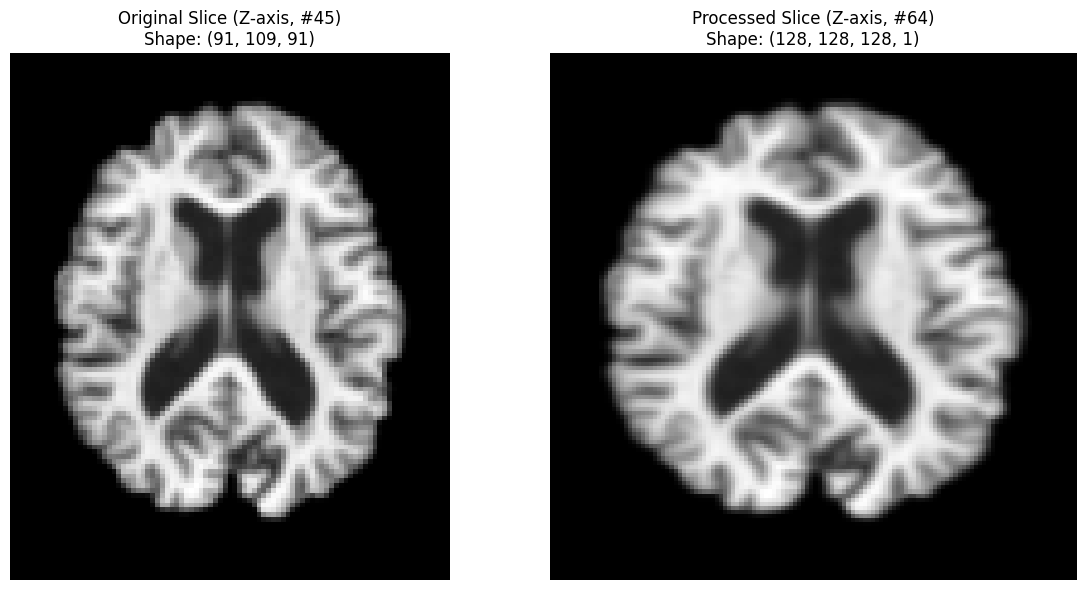

In [16]:
import matplotlib.pyplot as plt

# Plot them side-by-side
print("Displaying comparison:")
plt.figure(figsize=(12, 6))

# Subplot 1: Original
plt.subplot(1, 2, 1)
plt.imshow(original_slice.T, cmap='gray', origin='lower')
plt.title(f"Original Slice (Z-axis, #{middle_slice_idx})\nShape: {original_shape}")
plt.axis('off')

# Subplot 2: Processed
plt.subplot(1, 2, 2)
plt.imshow(processed_slice.T, cmap='gray', origin='lower')
plt.title(f"Processed Slice (Z-axis, #{middle_slice_processed_idx})\nShape: {processed_shape}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
df_clean.head()

,ID,CDR,Age,M/F,Educ,SES,MMSE,image_path
0,OAS1_0001_MR1,0.0,74,F,2.0,3.0,29.0,./oasis/OASIS/OAS1_0001_MR1_mpr_n4_anon_sbj_11...
1,OAS1_0002_MR1,0.0,55,F,4.0,1.0,29.0,./oasis/OASIS/OAS1_0002_MR1_mpr_n4_anon_sbj_11...
2,OAS1_0003_MR1,0.5,73,F,4.0,3.0,27.0,./oasis/OASIS/OAS1_0003_MR1_mpr_n4_anon_sbj_11...
3,OAS1_0004_MR1,0.0,28,M,3.0,2.0,29.0,./oasis/OASIS/OAS1_0004_MR1_mpr_n4_anon_sbj_11...
4,OAS1_0005_MR1,0.0,18,M,3.0,2.0,29.0,./oasis/OASIS/OAS1_0005_MR1_mpr_n4_anon_sbj_11...


In [18]:
# Encode the 'M/F' column
# 'M' -> 0
# 'F' -> 1
df_clean['M/F'] = df_clean['M/F'].map({'M': 0, 'F': 1})

# Prepare the target labels
# 0.0 -> 0
# 0.5 -> 1
# 1.0 -> 2
# 2.0 -> 3
df_clean['target'] = df_clean['CDR'].map({0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3})

# Final check
print("'M/F' and 'target' columns encoded\n\n")
print(df_clean.head())

'M/F' and 'target' columns encoded


              ID  CDR  Age  M/F  Educ  SES  MMSE  \
0  OAS1_0001_MR1  0.0   74    1   2.0  3.0  29.0   
1  OAS1_0002_MR1  0.0   55    1   4.0  1.0  29.0   
2  OAS1_0003_MR1  0.5   73    1   4.0  3.0  27.0   
3  OAS1_0004_MR1  0.0   28    0   3.0  2.0  29.0   
4  OAS1_0005_MR1  0.0   18    0   3.0  2.0  29.0   

                                          image_path  target  
0  ./oasis/OASIS/OAS1_0001_MR1_mpr_n4_anon_sbj_11...       0  
1  ./oasis/OASIS/OAS1_0002_MR1_mpr_n4_anon_sbj_11...       0  
2  ./oasis/OASIS/OAS1_0003_MR1_mpr_n4_anon_sbj_11...       1  
3  ./oasis/OASIS/OAS1_0004_MR1_mpr_n4_anon_sbj_11...       0  
4  ./oasis/OASIS/OAS1_0005_MR1_mpr_n4_anon_sbj_11...       0  


In [29]:
from sklearn.model_selection import train_test_split

X = df_clean
y = df_clean['target']


train_val_df, test_df = train_test_split(
    X,
    test_size=0.20, # 20% of the data for the final test set
    random_state=42,
    stratify=y
)

# Second Split (60% Train, 20% Val)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25, # 25% of the 80%
    random_state=42,
    stratify=train_val_df['target']
)

# Final Check
print("Data Splitting Complete\n")
print(f"Total samples:    {len(df_clean)}")
print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")

Data Splitting Complete

Total samples:    436
Training samples:   261
Validation samples: 87
Test samples:       88


In [30]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns we want to scale
features_to_scale = ['Age', 'Educ', 'SES', 'MMSE']

scaler = MinMaxScaler()

# Fit the scaler only on the training data
scaler.fit(train_df[features_to_scale])

# Transform all three datasets

train_df[features_to_scale] = scaler.transform(train_df[features_to_scale])
val_df[features_to_scale]   = scaler.transform(val_df[features_to_scale])
test_df[features_to_scale]  = scaler.transform(test_df[features_to_scale])

# Final Check
print("Tabular Data Scaling Complete\n\n")
print("Training Data Head:")
print(train_df.head())

Tabular Data Scaling Complete


Training Data Head:
                ID  CDR       Age  M/F  Educ   SES    MMSE  \
388  OAS1_0429_MR1  0.0  0.346154    1  0.50  0.25  0.9375   
183  OAS1_0201_MR1  0.0  0.858974    1  0.75  0.00  0.7500   
154  OAS1_0166_MR1  0.5  0.794872    1  0.25  0.25  0.8125   
85   OAS1_0091_MR1  0.0  0.000000    1  0.50  0.25  0.9375   
415  OAS1_0457_MR1  0.0  0.564103    1  0.50  0.50  0.7500   

                                            image_path  target  
388  ./oasis/OASIS/OAS1_0429_MR1_mpr_n4_anon_sbj_11...       0  
183  ./oasis/OASIS/OAS1_0201_MR1_mpr_n4_anon_sbj_11...       0  
154  ./oasis/OASIS/OAS1_0166_MR1_mpr_n4_anon_sbj_11...       1  
85   ./oasis/OASIS/OAS1_0091_MR1_mpr_n4_anon_sbj_11...       0  
415  ./oasis/OASIS/OAS1_0457_MR1_mpr_n3_anon_sbj_11...       0  


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from scipy.ndimage import rotate
import math

# Define 3D Augmentation Functions
def random_3d_rotation(img):
    """Applies a random rotation to a 3D image."""
    angle = np.random.uniform(-10, 10)
    return rotate(img, angle, axes=(0, 1), reshape=False, order=1, mode='nearest')

def random_horizontal_flip(img):
    """Randomly flips the image horizontally (left/right)."""
    if np.random.rand() > 0.5:
        return np.flip(img, axis=0)
    return img

# Define the columns for tabular data branch
TABULAR_FEATURES = ['Age', 'M/F', 'Educ', 'SES', 'MMSE']

BATCH_SIZE = 4

# Create the Data Generator Class
class MultimodalDataGenerator(Sequence):

    def __init__(self, df, batch_size, augment=False, shuffle=True):
        self.df = df.copy()
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle # Add a shuffle flag
        self.num_classes = 4
        self.indices = self.df.index.tolist()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        # Shuffles the data at the end of every epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        # Get indices for the current batch
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        # Handle the last batch
        batch_indices = self.indices[start_idx : end_idx]

        # Get the DataFrame rows for this batch
        batch_df = self.df.loc[batch_indices]

        # Initialize lists
        batch_X_image = []
        batch_X_tabular = []
        batch_y = []

        # Loop over each sample in the batch
        for i, row in batch_df.iterrows():
            img = process_scan(row['image_path'])

            if self.augment:
                img = random_3d_rotation(img)
                img = random_horizontal_flip(img)

            tabular_data = row[TABULAR_FEATURES].values.astype(np.float32)
            label = tf.keras.utils.to_categorical(row['target'], num_classes=self.num_classes)

            batch_X_image.append(img)
            batch_X_tabular.append(tabular_data)
            batch_y.append(label)

        batch_X_image = np.array(batch_X_image)
        batch_X_tabular = np.array(batch_X_tabular)
        batch_y = np.array(batch_y)

        # Return in the dictionary format Keras expects
        return ({'image_input': batch_X_image, 'tabular_input': batch_X_tabular}, batch_y)

print("\nData Generator Class defined successfully.")


Data Generator Class defined successfully.


In [32]:

print("Creating Training and Validation Generators...")


# Create the Training Generator with Augmentation
train_generator = MultimodalDataGenerator(
    df=train_df,
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

# Create the Validation Generator with no Augmentation
val_generator = MultimodalDataGenerator(
    df=val_df,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)

print("\nGenerators created successfully.")

Creating Training and Validation Generators...

Generators created successfully.


In [33]:
print("Creating final test generator...")
test_generator = MultimodalDataGenerator(
    df=test_df,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)

print(f"Test generator created with {len(test_df)} samples.")

Creating final test generator...
Test generator created with 88 samples.


Loading patient: OAS1_0429_MR1
Displaying augmentation comparison...


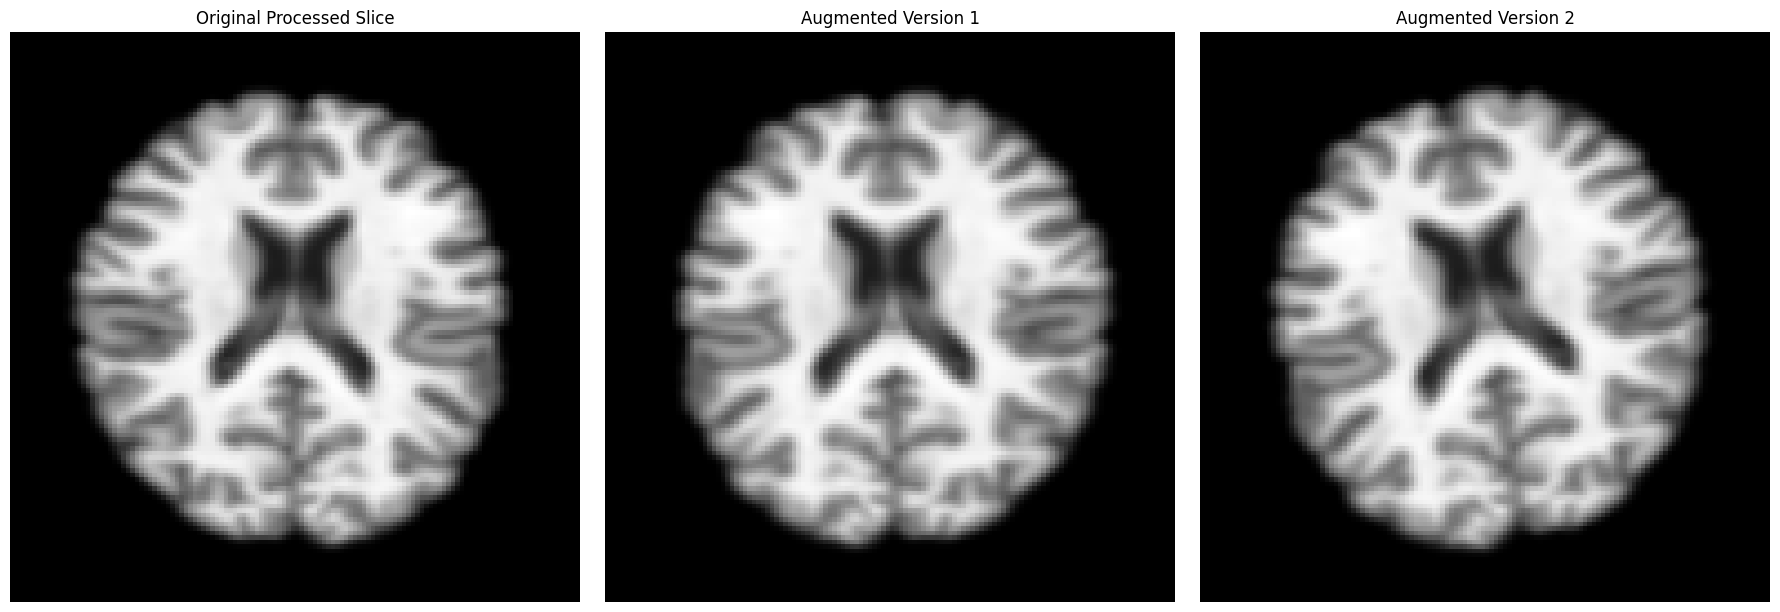

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get a Single Processed Image
# Get the first patient in our training set
first_train_patient = train_df.iloc[0]
print(f"Loading patient: {first_train_patient['ID']}")

# Load and process their scan
# This is "original" processed image
original_processed_img = process_scan(first_train_patient['image_path'])

# Create Augmented Versions
# Apply augmentation functions
augmented_img_1 = random_3d_rotation(original_processed_img)
augmented_img_1 = random_horizontal_flip(augmented_img_1)

# Run them again to get a different result
augmented_img_2 = random_3d_rotation(original_processed_img)
augmented_img_2 = random_horizontal_flip(augmented_img_2)

# Get the middle slices for plotting
slice_idx = IMG_SIZE // 2

original_slice = np.squeeze(original_processed_img[:, :, slice_idx, :])
augmented_slice_1 = np.squeeze(augmented_img_1[:, :, slice_idx, :])
augmented_slice_2 = np.squeeze(augmented_img_2[:, :, slice_idx, :])

# Plot all three
print("Displaying augmentation comparison...")
plt.figure(figsize=(18, 6))

# Plot 1: Original
plt.subplot(1, 3, 1)
plt.imshow(original_slice.T, cmap='gray', origin='lower')
plt.title("Original Processed Slice")
plt.axis('off')

# Plot 2: Augmented Version 1
plt.subplot(1, 3, 2)
plt.imshow(augmented_slice_1.T, cmap='gray', origin='lower')
plt.title("Augmented Version 1")
plt.axis('off')

# Plot 3: Augmented Version 2
plt.subplot(1, 3, 3)
plt.imshow(augmented_slice_2.T, cmap='gray', origin='lower')
plt.title("Augmented Version 2")
plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv3D, MaxPool3D, Flatten, Dense, Dropout,
    concatenate, GlobalAveragePooling3D
)

# Define the Tabular Data Branch (FNN)
def create_fnn():
    """Creates the Feed-Forward Network branch for tabular data."""
    input_shape = (len(TABULAR_FEATURES),)
    fnn_input = Input(shape=input_shape, name='tabular_input')
    x = Dense(32, activation='relu')(fnn_input)
    x = Dense(16, activation='relu')(x)
    fnn_model = Model(fnn_input, x, name='fnn_model')
    return fnn_model

# Define the Image Branch (3D CNN)
def create_cnn():
    """Creates the 3D Convolutional Neural Network branch for MRI scans."""
    input_shape = (IMG_SIZE, IMG_SIZE, IMG_SIZE, 1)
    cnn_input = Input(shape=input_shape, name='image_input')

    # Convolutional Block 1
    x = Conv3D(filters=16, kernel_size=3, activation='relu', padding='same')(cnn_input)
    x = MaxPool3D(pool_size=2, padding='same')(x) # 64x64x64

    # Convolutional Block 2
    x = Conv3D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPool3D(pool_size=2, padding='same')(x) # 32x32x32

    # Convolutional Block 3
    x = Conv3D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPool3D(pool_size=2, padding='same')(x) # 16x16x16

    # Head of the CNN
    x = GlobalAveragePooling3D()(x)
    x = Dense(64, activation='relu')(x)

    cnn_model = Model(cnn_input, x, name='cnn_model')
    return cnn_model

# Build and combine the branches
fnn_branch = create_fnn()
cnn_branch = create_cnn()

combined_input = concatenate([cnn_branch.output, fnn_branch.output])

# Add the final classifier head
x = Dense(32, activation='relu')(combined_input)
x = Dropout(0.5)(x)

final_output = Dense(4, activation='softmax', name='final_output')(x)

# Create the final multimodal model
model = Model(
    inputs=[cnn_branch.input, fnn_branch.input],
    outputs=final_output,
    name="multimodal_dementia_model"
)

model.summary()

Model: "multimodal_dementia_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 128, 128,  │        448 │ image_input[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 64, 64,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d_3[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_4[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling3d_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        192 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,592 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 4)         │        132 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,268 (301.83 KB)

 Trainable params: 77,268 (301.83 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from sklearn.utils import class_weight
import numpy as np

# Get all the training labels
# We use the 'target' column from the original train_df
train_labels = train_df['target']

# Calculate the weights
# This function automatically creates weights to balance the classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert the weights into a dictionary format
# Our classes are 0, 1, 2, 3
class_weights_dict = dict(enumerate(class_weights))

print("Class Weighting\n")
print(f"Calculated weights for classes [0, 1, 2, 3]:")
print(class_weights_dict)

Class Weighting

Calculated weights for classes [0, 1, 2, 3]:
{0: np.float64(0.3246268656716418), 1: np.float64(1.5535714285714286), 2: np.float64(4.078125), 3: np.float64(32.625)}


In [37]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Compiled Successfully")


Model Compiled Successfully


In [38]:
EPOCHS = 30

print("Starting baseline model training...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    verbose=1
)

print("\nModel Training Complete")

Starting baseline model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0970 - loss: 1.0927

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.0977 - loss: 1.0972 - val_accuracy: 0.1034 - val_loss: 1.3952
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.1534 - loss: 1.3817 - val_accuracy: 0.3333 - val_loss: 1.3898
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2090 - loss: 1.2200 - val_accuracy: 0.0805 - val_loss: 1.3890
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2379 - loss: 1.2562 - val_accuracy: 0.3678 - val_loss: 1.3862
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2761 - loss: 1.4676 - val_accuracy: 0.3448 - val_loss: 1.3884
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3369 - loss: 1.1600 - val_accuracy: 0.3103 - val_loss: 1.3857
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2888 - loss: 1.5628 - val_accuracy: 0.3793 - val_loss: 1.3774
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3437 - loss: 1.3521 - val_accuracy: 0.3793 - val_loss: 1.

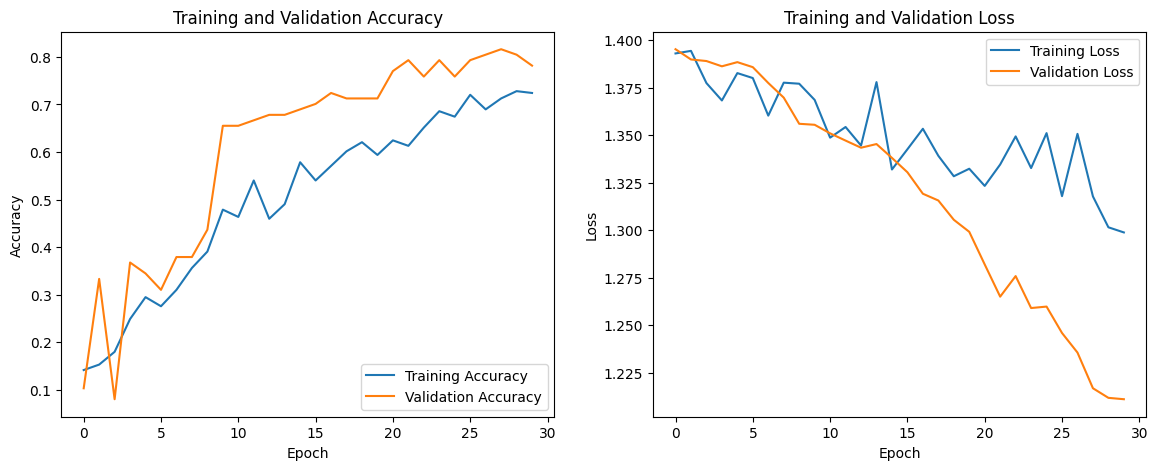

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [40]:
# Evaluate the model on the test generator
print("\nEvaluating Model on Unseen Test Data:")
test_loss, test_accuracy = model.evaluate(
    test_generator,
    verbose=1
)

print("\nFinal Model Performance (Baseline 3D-CNN):")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Evaluating Model on Unseen Test Data:


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 689ms/step - accuracy: 0.6950 - loss: 1.2365

Final Model Performance (Baseline 3D-CNN):
Test Loss:     1.2188
Test Accuracy: 77.27%


In [41]:
# Get all predictions
print("\nGenerating Predictions for Confusion Matrix...")
y_pred_probs = model.predict(test_generator)
# Convert probabilities to a single class (0, 1, 2, or 3)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels directly from our test_df
y_true = test_df['target'].values

print("\n\nPredictions Complete")


Generating Predictions for Confusion Matrix...
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 703ms/step


Predictions Complete


In [45]:
from sklearn.metrics import classification_report

# Define human-readable labels
class_names = ['Non-Demented (0)', 'Very Mild (1)', 'Mild (2)', 'Moderate (3)']

print("\nClassification Report:\n")

print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1, 2, 3],
    target_names=class_names,
    zero_division=0
))


Classification Report:

                  precision    recall  f1-score   support

Non-Demented (0)       0.88      0.93      0.90        68
   Very Mild (1)       0.00      0.00      0.00        14
        Mild (2)       0.33      0.83      0.48         6
    Moderate (3)       0.00      0.00      0.00         0

        accuracy                           0.77        88
       macro avg       0.30      0.44      0.34        88
    weighted avg       0.70      0.77      0.73        88




Confusion Matrix:


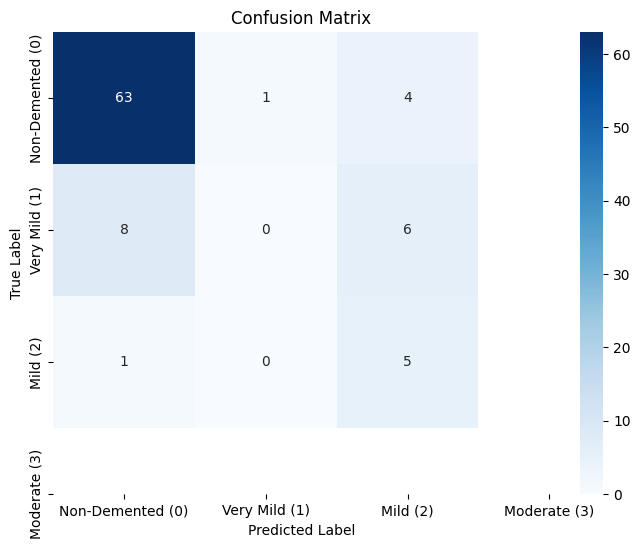

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [55]:
import pandas as pd

# Select 5 random samples from our test set
sample_df = test_df.sample(n=5)

print("Selected 5 Random Samples for Testing:")
print(sample_df[['ID', 'CDR', 'Age', 'M/F', 'Educ', 'SES', 'MMSE', 'target']])

Selected 5 Random Samples for Testing:
                ID  CDR       Age  M/F  Educ   SES    MMSE  target
435  OAS1_0395_MR2  0.0  0.102564    1  0.50  0.25  0.9375       0
206  OAS1_0227_MR1  0.0  0.102564    1  0.50  0.25  0.9375       0
346  OAS1_0382_MR1  1.0  0.628205    1  0.75  0.25  0.0625       2
243  OAS1_0270_MR1  0.0  0.961538    1  0.50  0.25  1.0000       0
49   OAS1_0054_MR1  0.0  0.038462    1  0.50  0.25  0.9375       0


In [56]:
import numpy as np

TABULAR_FEATURES = ['Age', 'M/F', 'Educ', 'SES', 'MMSE']

# Initialize empty lists to hold batch data
batch_X_image = []   # For 3D images
batch_X_tabular = [] # For clinical data
batch_y_true = []    # For the true labels

print("Processing 5 samples...")

# Loop over each of 5 samples
for i, row in sample_df.iterrows():

    # Load and process the 3D image
    img = process_scan(row['image_path'])

    # Get the scaled tabular data
    tabular_data = row[TABULAR_FEATURES].values.astype(np.float32)

    # Get the true label
    label = row['target']

    # Add the processed data to our batch lists
    batch_X_image.append(img)
    batch_X_tabular.append(tabular_data)
    batch_y_true.append(label)

# Convert the lists to numpy arrays that the model can understand
batch_X_image = np.array(batch_X_image)
batch_X_tabular = np.array(batch_X_tabular)
batch_y_true = np.array(batch_y_true, dtype=int) # Ensure labels are integers

print("Data prepared in batch format.\n")
print(f"Image batch shape:   {batch_X_image.shape}")
print(f"Tabular batch shape: {batch_X_tabular.shape}")
print(f"True Label batch shape: {batch_y_true.shape}")

Processing 5 samples...
Data prepared in batch format.

Image batch shape:   (5, 128, 128, 128, 1)
Tabular batch shape: (5, 5)
True Label batch shape: (5,)


In [57]:
import numpy as np

print("Making predictions on the 5 samples...")

# Create the dictionary input that model expects
inputs = {
    'image_input': batch_X_image,
    'tabular_input': batch_X_tabular
}

# Get the model's predictions (these are probabilities)
preds_prob = model(inputs, training=False)

# Convert probabilities to a single class index (0, 1, 2, or 3)
y_pred = np.argmax(preds_prob, axis=1)

print("\n\nPredictions complete.")

Making predictions on the 5 samples...


Predictions complete.


In [58]:
# Define our human-readable labels again
class_names = ['Non-Demented (0)', 'Very Mild (1)', 'Mild (2)', 'Moderate (3)']

print("="*40)
print("     FINAL PREDICTION REPORT (5 SAMPLES)")
print("="*40)

# Loop from 0 to 4 (for our 5 samples)
for i in range(5):
    # Get the patient ID
    patient_id = sample_df.iloc[i]['ID']

    # Get the TRUE label index (e.g., 0)
    true_label_index = batch_y_true[i]

    # Get the PREDICTED label index (e.g., 1)
    pred_label_index = y_pred[i]

    # Get the human-readable names
    true_label_name = class_names[true_label_index]
    pred_label_name = class_names[pred_label_index]

    # Check if the prediction was correct
    result = "CORRECT" if true_label_index == pred_label_index else "INCORRECT"

    # Print the report for this sample
    print(f"\n--- Sample {i+1}: {patient_id} ---")
    print(f"    TRUE LABEL:      {true_label_name}")
    print(f"    MODEL PREDICTION: {pred_label_name}")
    print(f"    RESULT:          {result}")

print("\n" + "="*40)

     FINAL PREDICTION REPORT (5 SAMPLES)

--- Sample 1: OAS1_0395_MR2 ---
    TRUE LABEL:      Non-Demented (0)
    MODEL PREDICTION: Non-Demented (0)
    RESULT:          CORRECT

--- Sample 2: OAS1_0227_MR1 ---
    TRUE LABEL:      Non-Demented (0)
    MODEL PREDICTION: Non-Demented (0)
    RESULT:          CORRECT

--- Sample 3: OAS1_0382_MR1 ---
    TRUE LABEL:      Mild (2)
    MODEL PREDICTION: Mild (2)
    RESULT:          CORRECT

--- Sample 4: OAS1_0270_MR1 ---
    TRUE LABEL:      Non-Demented (0)
    MODEL PREDICTION: Non-Demented (0)
    RESULT:          CORRECT

--- Sample 5: OAS1_0054_MR1 ---
    TRUE LABEL:      Non-Demented (0)
    MODEL PREDICTION: Non-Demented (0)
    RESULT:          CORRECT

